In [1]:
from gurobipy import *
import numpy as np
import pandas as pd
from scipy.spatial import distance
from itertools import chain, combinations
import matplotlib.pyplot as plt
import os, sys
import readData as dt
import math 

In [2]:
dt = dt.Data()
dt.get_data("input/test.txt")

dt.X

[30, 37, 49, 52, 31, 52, 42, 52, 57, 62]

In [3]:
dt.m_distance_matrix

[[0, 19, 22, 46, 23, 29, 13, 23, 45, 34, 0],
 [19, 0, 21, 27, 16, 34, 16, 26, 26, 35, 19],
 [22, 21, 0, 24, 37, 13, 9, 5, 23, 14, 22],
 [46, 27, 24, 0, 23, 31, 33, 23, 11, 32, 46],
 [23, 16, 37, 23, 0, 50, 32, 42, 30, 51, 23],
 [29, 34, 13, 31, 50, 0, 18, 8, 30, 19, 29],
 [13, 16, 9, 33, 32, 18, 0, 10, 32, 21, 13],
 [23, 26, 5, 23, 42, 8, 10, 0, 22, 11, 23],
 [45, 26, 23, 11, 30, 30, 32, 22, 0, 21, 45],
 [34, 35, 14, 32, 51, 19, 21, 11, 21, 0, 34]]

In [4]:
dt.distance_matrix

[[0, 13.89, 19.24, 32.56, 22.02, 23.09, 12.04, 22.02, 32.45, 32.06, 0],
 [13.89, 0, 15.0, 19.21, 11.66, 24.21, 12.08, 18.6, 20.88, 26.93, 13.89],
 [19.24, 15.0, 0, 21.21, 26.17, 10.44, 7.28, 3.61, 17.0, 13.04, 19.24],
 [32.56, 19.21, 21.21, 0, 21.1, 31.0, 25.08, 23.0, 7.81, 24.17, 32.56],
 [22.02, 11.66, 26.17, 21.1, 0, 35.81, 23.71, 29.7, 26.31, 36.89, 22.02],
 [23.09, 24.21, 10.44, 31.0, 35.81, 0, 12.81, 8.0, 25.5, 13.45, 23.09],
 [12.04, 12.08, 7.28, 25.08, 23.71, 12.81, 0, 10.0, 22.67, 20.02, 12.04],
 [22.02, 18.6, 3.61, 23.0, 29.7, 8.0, 10.0, 0, 17.72, 10.05, 22.02],
 [32.45, 20.88, 17.0, 7.81, 26.31, 25.5, 22.67, 17.72, 0, 16.76, 32.45],
 [32.06, 26.93, 13.04, 24.17, 36.89, 13.45, 20.02, 10.05, 16.76, 0, 32.06]]

In [5]:
#Set
C = [] #set of customers
C_0 = [] #set of customers and depot
C_plus = [] #set of customers and copy of depot
N = [] #set of all nodes
K = [] #set of trucks
D = [] #set of small drones
Q = [] #set of customers' demand
CL = [] #set of low-perishability products customers
CH = [] #set of high-perishability products customers
#

T = None #completion time
QT = None #truck capacity

QSD = None #small drone capacity


#



In [6]:
dt.num_of_truck = 2

dt.num_of_small_drone = 5

In [7]:
n = dt.num_of_customer - 1

C = [i for i in range(1, n+1)]
C_0 = [i for i in range(0, n+1)]
C_plus = [i for i in range(1, n + 2)]
N = [i for i in range(0, n+2)]
K = [i for i in range(dt.num_of_truck)]
D = [i for i in range(dt.num_of_small_drone)]
Q = dt.demand_matrix
Q.append(0)
CL = [i for i in range(5,10)]
CH = [i for i in range(1,5)]
QT = dt.truck_capacity
QD = 17
TL = 50
TH = 100
sp = 2
cost_t = dt.m_distance_matrix
cost_td = dt.distance_matrix
M = GRB.MAXINT
theta = 1
phi_low = 0.002
phi_high = 0.02
CD = C
CD

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
 # initializing drone time matrix
for i in range(dt.num_of_customer):
    for j in range(dt.num_of_customer):
        cost_td[i][j] = cost_td[i][j] / sp
for i in range(dt.num_of_customer):
    for j in range(dt.num_of_customer):
           cost_td[i][j] = round(cost_td[i][j], 2)
cost_td

[[0.0, 6.95, 9.62, 16.28, 11.01, 11.54, 6.02, 11.01, 16.23, 16.03, 0],
 [6.95, 0.0, 7.5, 9.61, 5.83, 12.11, 6.04, 9.3, 10.44, 13.46, 13.89],
 [9.62, 7.5, 0.0, 10.61, 13.09, 5.22, 3.64, 1.8, 8.5, 6.52, 19.24],
 [16.28, 9.61, 10.61, 0.0, 10.55, 15.5, 12.54, 11.5, 3.9, 12.09, 32.56],
 [11.01, 5.83, 13.09, 10.55, 0.0, 17.91, 11.86, 14.85, 13.15, 18.45, 22.02],
 [11.54, 12.11, 5.22, 15.5, 17.91, 0.0, 6.41, 4.0, 12.75, 6.72, 23.09],
 [6.02, 6.04, 3.64, 12.54, 11.86, 6.41, 0.0, 5.0, 11.34, 10.01, 12.04],
 [11.01, 9.3, 1.8, 11.5, 14.85, 4.0, 5.0, 0.0, 8.86, 5.03, 22.02],
 [16.23, 10.44, 8.5, 3.9, 13.15, 12.75, 11.34, 8.86, 0.0, 8.38, 32.45],
 [16.03, 13.46, 6.52, 12.09, 18.45, 6.72, 10.01, 5.03, 8.38, 0.0, 32.06]]

In [9]:
#variables
x = {}


y = {}
yd = {}

t = {}
td = {}

u = {}
w1 = {}
w2 = {}
w3 = {}
w4 = {}
w5 = {}
w6 = {}
model = Model('VRPTD')

Set parameter Username


In [10]:

for k in K:
    for i in N:
        w1[k,i] = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS,name = "w1%d,%d" %(k,i))

for d in D:
    for i in N:
        w2[d,i] = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS,name = "w2%d,%d" %(d,i))


for k in K:
    for i in N:
        w3[k,i] = model.addVar(0,1,name = "w3%d,%d" %(k,i))

for d in D:
    for i in N:
        w4[d,i] = model.addVar( lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS,name = "w4%d,%d" %(d,i))
for k in K:
    for i in N:
        w5[k,i] = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS,name = "w5%d,%d" %(k,i))

for d in D:
    for i in N:
        w6[d,i] = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS,name = "w6%d,%d" %(d,i))
        
        

In [11]:

#DECISION VARIABLES
for k in K:
    for i in N:
        y[k,i] = model.addVar(0, 1, vtype = GRB.BINARY,name = "y%d,%d" %(k,i))
        for j in N:
            x[k,i,j] = model.addVar(0, 1, vtype = GRB.BINARY,name = "x%d,%d,%d" %(k,i,j))

# for cd in CD:
#     for i in N:
#         yd[d,i] = model.addVar(0, 1, vtype = GRB.BINARY,name = "ycd%d,%d" %(cd,i))
#         for j in N:
#             xcd[cd,i,j] = model.addVar(0, 1, vtype = GRB.BINARY,name = "xcd%d,%d,%d" %(cd,i,j))
            
for d in D:
    for i in C:
        yd[d,i] = model.addVar(0, 1, vtype = GRB.BINARY,name = "yd%d,%d" %(d,i))
#         xd[d,i] = model.addVar(0, 1, vtype = GRB.BINARY,name = "xd%d,%d" %(d,i))

for k in K:
    for i in N:
        t[k,i] = model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, name = "t%d,%d" %(k,i))
        
        
for d in D:
    for i in N:
        td[d,i] = model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, name = "td%d,%d" %(d,i))
for k in K:
    for i in N:
        u[k,i] = model.addVar(0, GRB.INFINITY, vtype = GRB.CONTINUOUS, name = "u%d" %i)





                
QDV = model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, "QDV")    
alpha = model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, "traveltime")

expr0 = LinExpr(0)
expr1 = LinExpr(0)
expr0.addTerms(theta, QDV)
expr1.addTerms(1-theta, alpha)
model.setObjective(expr0 + expr1, GRB.MINIMIZE)



#objective
tmp_expr0 = LinExpr(0)
tmp_expr1 = LinExpr(0)
tmp_expr2 = LinExpr(0)
for k in K:
    tmp_expr0.addTerms(1.0, t[k, n+1])
for d in D:
    for i in C:
        tmp_expr1.addTerms(1.0, td[d, i])
model.addConstr(alpha >= tmp_expr0 + tmp_expr1 )

# model.update()
# print(tmp_expr0)
# print(tmp_expr1)
# print(tmp_expr2)



    
#TDV
QDVL_truck = QuadExpr(0)
QDVL_drone = QuadExpr(0)
QDVH_truck = QuadExpr(0)
QDVH_drone = QuadExpr(0)
for i in CL:
    for k in K:
        
        QDVL_truck.addTerms(Q[i]*phi_low, t[k,i], y[k,i])
        model.update()
       
    for d in D:
        if i in CD:
            QDVL_drone.addTerms(Q[i]*phi_low, td[d,i], yd[d,i])
for i in CH:
    for k in K:
        
        QDVH_truck.addTerms(Q[i]*phi_high, t[k,i], y[k,i])
        model.update()
       
    for d in D:
        if i in CD:
            QDVH_drone.addTerms(Q[i]*phi_high, td[d,i], yd[d,i])

#e^-phi_high*t

# for i in CH:
#     for k in K:
#         model.addConstr(w1[k,i] == -phi_high*t[k,i])

# for i in CH:
#     for d in D:
#         if i in CD:
#             model.addConstr(w2[d,i] == -phi_high* td[d,i])
# for i in CH:
#     for k in K:
#         model.addGenConstrExp(w1[k,i], w3[k,i],"FuncPieces=-1 FuncPieceError=0.001")
        
# for i in CH:
#     for d in D:
#         if i in CD:
#             model.addGenConstrExp(w2[d,i],w4[d,i], "FuncPieces=-1 FuncPieceError=0.001")

# for i in CH:
#     for k in K:
#         model.addConstr(w5[k,i] == 1 - w3[k,i])

# for i in CH:
#     for d in D:
#         model.addConstr(w6[d,i] == 1 - w4[d,i])

# for i in CH:
#     for k in K:
#         QDVH_truck.addTerms(Q[i], w5[k,i] , y[k,i])
#     for d in D:
#         if i in CD:
#             QDVH_drone.addTerms(Q[i], w6[d,i], yd[d,i])    
# for i in CH:
#     for k in K:
#         tmp_truck = -phi_high*t[k,i]
#         QDVH_truck.addTerms(Q[i], 1 - math.exp(tmp_truck), y[k,i])
#     for d in D:
#         if i in CD:
#             tmp_drone = -phi_high*td[d,i]
#             QDVH_drone.addTerms(Q[i], 1 - math.exp(tmp_drone), yd[d,i])  
        
model.addConstr(QDV >= QDVL_truck + QDVL_drone + QDVH_truck +QDVH_drone )


tmp_expr0 = LinExpr(0)
tmp_expr1 = LinExpr(0)

for k in K:
     for i in C_0:
            for j in C_plus:
                tmp_expr0.addTerms(cost_t[i][j], x[k, i,j])

for d in D:
    for i in C:
        tmp_expr1.addTerms(2*cost_td[0][i], yd[d, i])
model.addConstr(alpha >= tmp_expr0 + tmp_expr1)

#2
for i in C:
    tmp_expr0 = LinExpr(0)
    tmp_expr1 = LinExpr(0)
    
    for k in K:
        tmp_expr0.addTerms(1.0, y[k,i])
    
    for d in D:
        tmp_expr1.addTerms(1.0, yd[d,i])
#     model.update()
#     print(tmp_expr0)
    model.addConstr(tmp_expr0 + tmp_expr1  == 1)
#3
for k in K:
    tmp_expr = LinExpr(0)
    for i in C_plus:
        tmp_expr.addTerms(1.0, x[k,0,i])
    model.addConstr(tmp_expr == 1)
    tmp_expr.clear()

#4
for k in K:
    tmp_expr = LinExpr(0)
    for i in C_0:
        tmp_expr.addTerms(1.0, x[k,i,n+1])
    model.addConstr(tmp_expr == 1)
    tmp_expr.clear()
    
#5
for i in C:
    for k in K:
        tmp_expr0 = LinExpr(0)
        tmp_expr1 = LinExpr(0)
        for j in C_0:
            tmp_expr0.addTerms(1.0, x[k,j,i])
        for j in C_plus:
            tmp_expr1.addTerms(1.0, x[k,i,j])
        model.addConstr(tmp_expr1 == tmp_expr0) 
        model.addConstr(y[k,i] == tmp_expr0) 
        model.addConstr(y[k,i] == tmp_expr1) 
        tmp_expr0.clear()
        tmp_expr1.clear()


#9
# for d in D:
#     tmp_expr = LinExpr(0)
#     for i in C:
# # TDL = LinExpr(0)

# # for k in K:
# #     for i in CL:
# #         tmp_expr0.addTerms(,y[k,i])
#         tmp_expr.addTerms(1.0, yd[d,i])
#     model.addConstr(tmp_expr <= 1)
    
#10

for k in K:
    tmp_expr = LinExpr(0)
    for i in C:
        tmp_expr.addTerms(Q[i], y[k,i])
    model.addConstr(tmp_expr <= QT)
    tmp_expr.clear()
    
# #11
# for cd in CD:
#     tmp_expr = LinExpr(0)
#     for i in C:
#         tmp_expr.addTerms(D[i], ycd[cd,i])
#     model.addConstr(tmp_expr <= QCD)
#     tmp_expr.clear()
        
#12
for d in D:
    tmp_expr = LinExpr(0)
    for i in C:
        tmp_expr.addTerms(Q[i], yd[d,i])
    model.addConstr(tmp_expr <= QD)
    tmp_expr.clear()
#13 arrival time

for i in C_0:
    for j in C_plus:
        for k in K:
            model.addConstr(t[k,j] >= t[k,i] + cost_t[i][j] - M*(1-x[k,i,j]))


#15

for i in C:
    for d in D:
        model.addConstr(td[d,i] >= 2*cost_td[0][i]    - M*(1 - yd[d,i]) )
                            
# for i in C:
#         for d in d:
#             model.addConstr(td[d,i] == yd[d,i]*cost_td[0][i])           
# 16

# for i in CL:
#     tmp_expr0 = QuadExpr(0)
#     tmp_expr1 = QuadExpr(0)

   
#     for k in K:
#         tmp_expr0.addTerms(1.0, t[k,i], y[k,i])
      
        
#     for d in D:
#         tmp_expr1.addTerms(1.0, td[d,i], yd[d,i])
#         print(tmp_expr1)
        
#     model.addConstr(tmp_expr0 + tmp_expr1 <= TL)
                    
# #17
# for i in CH:
#     tmp_expr0 = QuadExpr(0)
#     tmp_expr1 = QuadExpr(0)
  
#     for k in K:
#         tmp_expr0.addTerms(1.0, t[k,i], y[k,i])
#         model.update()
#         print (tmp_expr0)
        
#     for d in D:
#         tmp_expr1.addTerms(1.0, td[d,i], yd[d,i])
        
#     model.addConstr(tmp_expr0 + tmp_expr1  <= TH)

#18
for i in N:
    for j in N:
        for k in K:
            tmp0 = u[k,i] - u[k,j] + QT*x[k,i,j]
            tmp1 = QT - Q[j]
            
            model.addConstr(tmp0 <= tmp1)
#19

for i in N:
    for k in K:
        model.addConstr(u[k,i] >= Q[i])
        model.addConstr(u[k,i] <= QT)


                    
#domain constraints
# for k in K:
#     for j in C:
#         model.addConstr(t[k,j] >= 0)
# for cd in CD:
#     for j in C:
#         model.addConstr(tcd[cd,j] >= 0)
# for d in d:
#     for j in C:
#         model.addConstr(td[d,j] >= 0)

In [12]:

model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 607 rows, 641 columns and 2540 nonzeros
Model fingerprint: 0xb570d2d7
Model has 1 quadratic constraint
Variable types: 332 continuous, 309 integer (309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+09]
  QMatrix range    [2e-02, 6e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 212 rows and 370 columns
Presolve time: 0.01s
Presolved: 471 rows, 385 columns, 3072 nonzeros
Presolved model has 76 SOS constraint(s)
Variable types: 132 continuous, 253 integer (253 binary)

Root relaxation: objective 1.232480e+00, 147 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

In [13]:
model.printAttr('x')


    Variable            x 
-------------------------
      x0,0,4            1 
        y0,3            1 
     x0,3,10            1 
        y0,4            1 
      x0,4,8            1 
        y0,8            1 
      x0,8,3            1 
      x1,0,1            1 
        y1,1            1 
      x1,1,6            1 
        y1,2            1 
     x1,2,10            1 
        y1,6            1 
      x1,6,2            1 
       yd0,9            1 
       yd2,7            1 
       yd4,5            1 
        t0,3           11 
        t0,4           23 
        t0,8           30 
       t0,10           28 
        t1,1           19 
        t1,2            9 
        t1,6           16 
       t1,10           11 
       td0,9        32.06 
       td2,7        22.02 
       td4,5        23.08 
          u1           19 
          u2           80 
          u3           80 
          u4           23 
          u5           80 
          u6           80 
          u7           15 
 

In [14]:
dt.X[0]

30

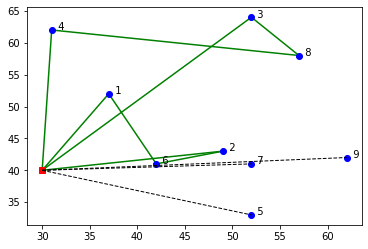

In [15]:

truck_tours = [[] for k in K]


for k in K:
    truck_tours[k] = [(i,j) for i in C_0 for j in C_plus if x[k,i,j].x > 0.99 ]
plt.plot(dt.X[0], dt.Y[0], c='r', marker='s')

for i in range(1, dt.num_of_customer):
    plt.scatter(dt.X[i], dt.Y[i], c='b')
    plt.annotate(str("  ") + str(int(i)), (dt.X[i], dt.Y[i]))
    
for k in K:
    for i, j in truck_tours[k]:
        if j != dt.num_of_customer:
            plt.plot([dt.X[i], dt.X[j]], [dt.Y[i], dt.Y[j]], c='g', zorder=0)
        else:
            for k, h in truck_tours[k]:
                if h == i:
                    plt.plot([dt.X[i], dt.X[0]], [dt.Y[i], dt.Y[0]], c='g', zorder=0)


                    
for d in D:
    default_width= 1
    for i in C:
        if yd[d,i].x > 0.99:
            plt.plot([dt.X[0],dt.X[i]], [dt.Y[0], dt.Y[i]], color='black', linestyle='dashed', linewidth = default_width)
    



